In [1]:
import numpy as np
import pandas as pd
import scipy

In [2]:
from ecoevocrm.consumer_resource_system import *
from ecoevocrm.landscapes import *
import ecoevocrm.utils as utils
import ecoevocrm.viz as viz
import ecoevocrm.coarse_graining as cg
import ecoevocrm.strain_pool

In [3]:
import matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns

----

## Model parameters

### Traits

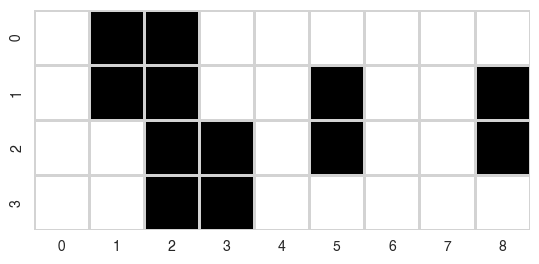

In [4]:
                       # h  h  h  h  h   t   m  m  m
traits_init = np.array([[0, 1, 1, 0, 0,  0,  0, 0, 0],   # pf|A
                        [0, 1, 1, 0, 0,  1,  0, 0, 1],   # pc|A
                        [0, 0, 1, 1, 0,  1,  0, 0, 1],   # pc|B
                        [0, 0, 1, 1, 0,  0,  0, 0, 0]])  # pf|B
viz.matrix_plot(traits_init, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

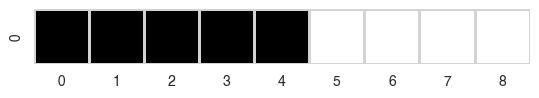

In [5]:
h = 1
consumption_rates = np.array([h, h, h, h, h, 0, 0, 0, 0])  # for all types
viz.matrix_plot(consumption_rates, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

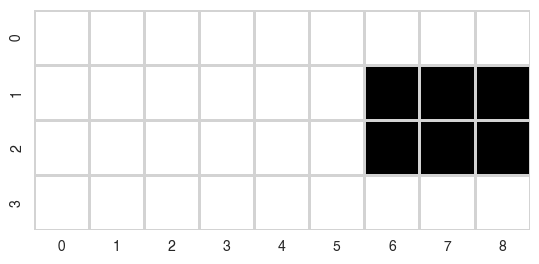

In [6]:
m = 1e-9
mutation_rates = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0],   # pf|A 
                           [0, 0, 0, 0, 0, 0, m, m, m],   # pc|A
                           [0, 0, 0, 0, 0, 0, m, m, m],   # pc|B
                           [0, 0, 0, 0, 0, 0, 0, 0, 0]])  # pf|B
viz.matrix_plot(mutation_rates, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

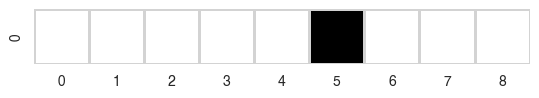

In [7]:
l = 1e-9
segregation_rates = np.array([0, 0, 0, 0, 0, l, 0, 0, 0])  # for all types
viz.matrix_plot(segregation_rates, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

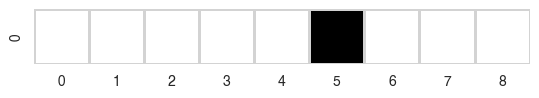

In [8]:
b = 1e-12
a = 1
transfer_donor_rates = np.array([0, 0, 0, 0, 0, b, 0, 0, 0])  # for all types
transfer_recip_rates = np.array([0, 0, 0, 0, 0, a, 0, 0, 0])  # for all types
viz.matrix_plot(transfer_donor_rates, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)
viz.matrix_plot(transfer_recip_rates, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

In [9]:
linkage = {5: [6, 7, 8]}

In [10]:
N_init = np.ones(traits_init.shape[0])
N_init

array([1., 1., 1., 1.])

### Costs

In [11]:
cost_baseline = 0.1

In [12]:
N = 3
K = 0

In [13]:
landscape_hostA = NKLandscape(N=N, K=K, seed=1)
landscape_hostA.genotype_fitnesses

{'000': 0.6865741075307201,
 '001': 0.43225692807333055,
 '010': 0.7760595339862766,
 '011': 0.521742354528887,
 '100': 0.5050252348051697,
 '101': 0.25070805534778007,
 '110': 0.5945106612607262,
 '111': 0.34019348180333653}

In [14]:
landscape_hostB = NKLandscape(N=N, K=K, seed=2)
landscape_hostB.genotype_fitnesses

{'000': 0.7880068580442484,
 '001': 0.7332693048201989,
 '010': 0.5235722118980658,
 '011': 0.46883465867401636,
 '100': 0.7104474665596117,
 '101': 0.6557099133355622,
 '110': 0.446012820413429,
 '111': 0.39127526718937955}

In [15]:
landscape = merge_landscapes(landscape_hostA.genotype_fitnesses, landscape_hostB.genotype_fitnesses, prefix_A='011001', prefix_B='001101')  # prefixes = traits for pc|A and pc|B

In [16]:
landscape.update({'011000000': max(landscape_hostA.genotype_fitnesses.values()),   # pf|A
                  '001100000': max(landscape_hostB.genotype_fitnesses.values())})  # pf|B

In [17]:
landscape

{'011001000': 0.6865741075307201,
 '011001001': 0.43225692807333055,
 '011001010': 0.7760595339862766,
 '011001011': 0.521742354528887,
 '011001100': 0.5050252348051697,
 '011001101': 0.25070805534778007,
 '011001110': 0.5945106612607262,
 '011001111': 0.34019348180333653,
 '001101000': 0.7880068580442484,
 '001101001': 0.7332693048201989,
 '001101010': 0.5235722118980658,
 '001101011': 0.46883465867401636,
 '001101100': 0.7104474665596117,
 '001101101': 0.6557099133355622,
 '001101110': 0.446012820413429,
 '001101111': 0.39127526718937955,
 '011000000': 0.7760595339862766,
 '001100000': 0.7880068580442484}

### Environment

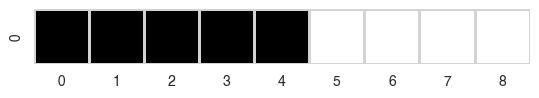

In [18]:
R_init = np.zeros(traits_init.shape[1])
R_init[consumption_rates > 0] = 1
viz.matrix_plot(R_init, vmin=0, vmax=1, cbar=False, linecolor='lightgray', linewidths=1)

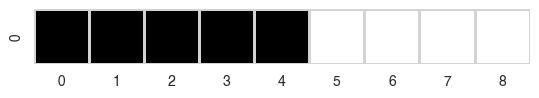

In [19]:
influx_rates = np.zeros(traits_init.shape[1])
influx_rates[consumption_rates > 0] = 1
viz.matrix_plot(influx_rates, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

In [20]:
decay_rates = 1

In [21]:
carrying_capacity = 1e9

## Simulate model

In [22]:
system = ConsumerResourceSystem(traits=traits_init, 
                                consumption_rate=consumption_rates, carrying_capacity=carrying_capacity, 
                                cost_landscape=landscape, cost_baseline=cost_baseline, 
                                mutation_rate=mutation_rates, segregation_rate=segregation_rates,
                                segregation_linkage=linkage, transfer_linkage=linkage,
                                influx_rate=influx_rates, decay_rate=decay_rates,
                                N_init=N_init, R_init=R_init, seed=2)

In [23]:
system.type_set.energy_costs

array([0.87605953, 0.53225693, 0.8332693 , 0.88800686])

In [24]:
T_total = 1e6

In [25]:
system.run(T=T_total)

[ Mutation event occurred at  t=20.6010 4/4*(6)]	
[ Mutation event occurred at  t=27.6905 5/5*(9)]	
[ Mutation event occurred at  t=32.3183 6/6*(12)]	
[ Mutation event occurred at  t=34.2324 7/7*(15)]	
[ Mutation event occurred at  t=37.5614 8/8*(18)]	
[ Mutation event occurred at  t=46.3141 9/9*(21)]	
[ Mutation event occurred at  t=47.5864 10/10*(24)]	
[ Mutation event occurred at  t=49.3557 11/11*(27)]	
[ Mutation event occurred at  t=67.6418 12/12*(30)]	
[ Mutation event occurred at  t=438.7189 12/13*(33)]	
[ Mutation event occurred at  t=466.9373 10/14*(36)]	
[ Mutation event occurred at  t=490.2358 11/15*(39)]	
[ Mutation event occurred at  t=496.0999 12/16*(42)]	
[ Mutation event occurred at  t=507.4758 13/17*(45)]	
[ Mutation event occurred at  t=518.8152 14/18*(48)]	
[ Mutation event occurred at  t=548.2234 15/19*(51)]	
[ Mutation event occurred at  t=596.9480 16/20*(54)]	
[ Mutation event occurred at  t=631.7087 17/21*(57)]	


<AxesSubplot: >

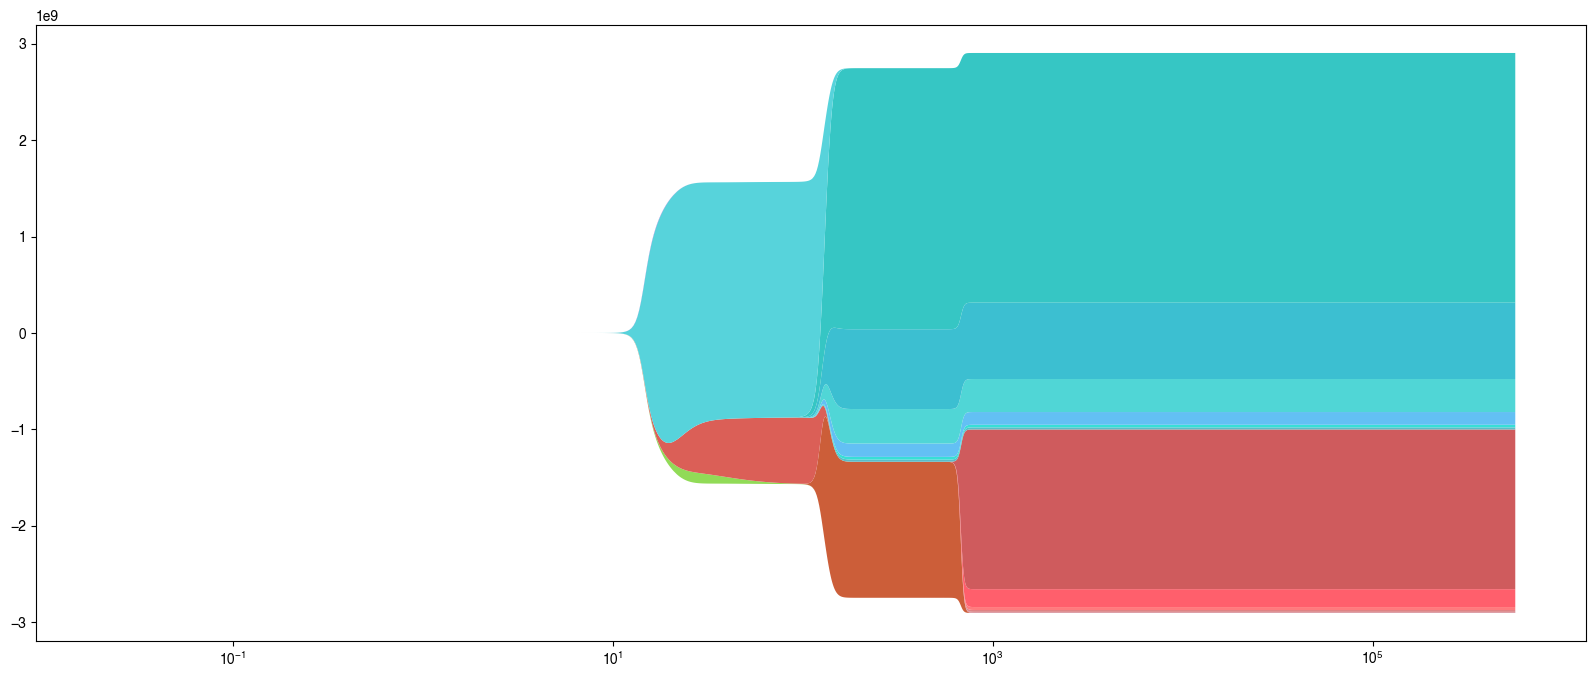

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
viz.stacked_abundance_plot(system, ax=ax, relative_abundance=False, apply_palette_depth=0, log_x_axis=True, color_seed=1)

<AxesSubplot: >

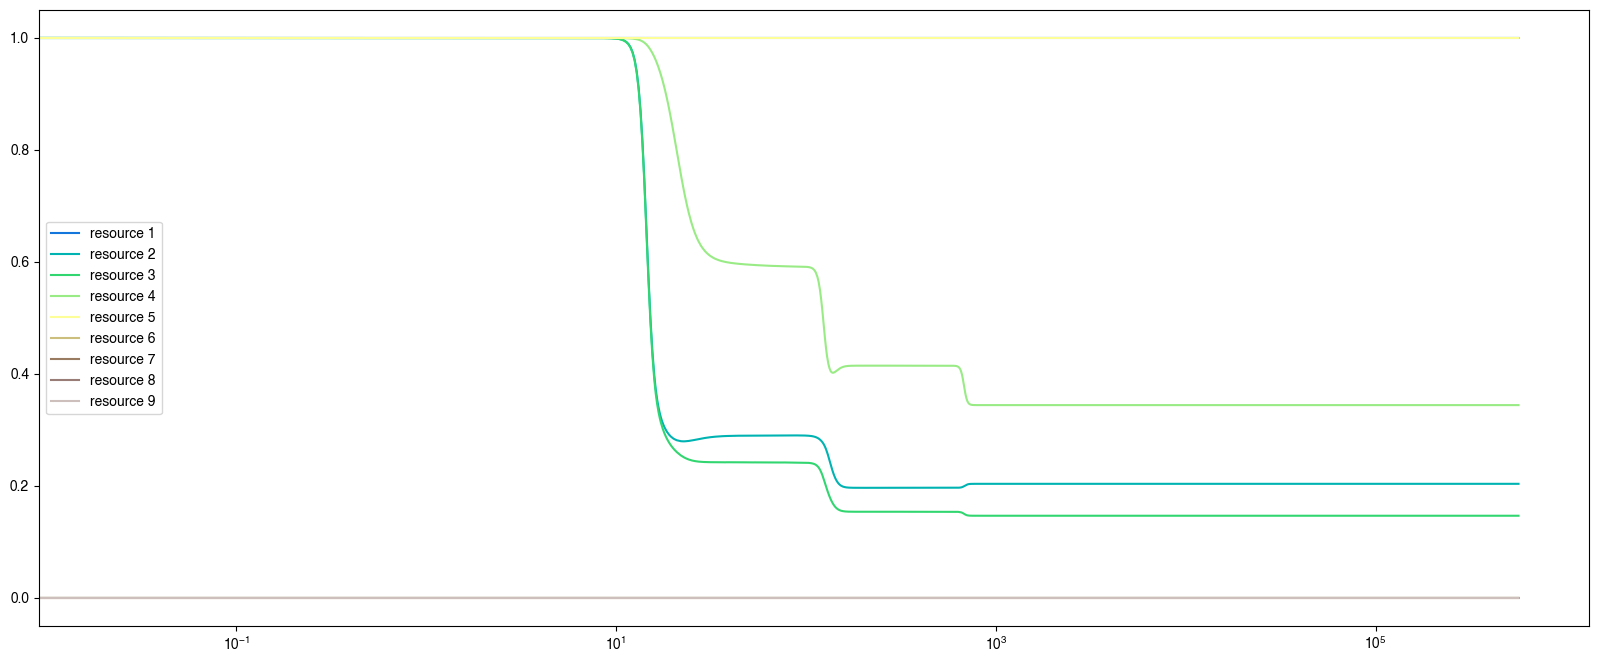

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
viz.resource_plot(system, ax=ax, stacked=False, relative=False, log_x_axis=True, log_y_axis=False)

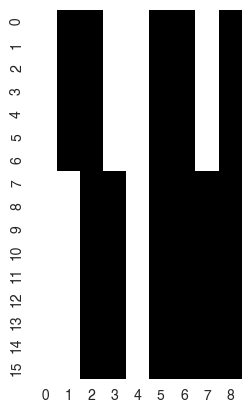

In [28]:
viz.matrix_plot(system.extant_type_set.traits)

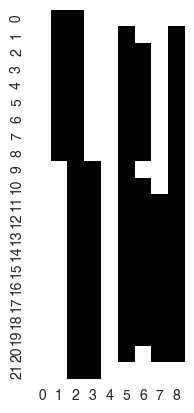

In [29]:
viz.matrix_plot(system.type_set.traits)

In [30]:
class SystemParameter():

    def __init__(self, values, num_types, num_traits, force_type_dim=False, force_trait_dim=False):
        
        self.num_types  = num_types
        self.num_traits = num_traits
        
        self.force_type_dim  = force_type_dim
        self.force_trait_dim = force_trait_dim
        
        if(not isinstance(values, (list, np.ndarray))):  # scalar
            if(force_type_dim and force_trait_dim):
                self._values = utils.ExpandableArray( np.full(shape=(num_types, num_traits), fill_value=values) )
                self.has_type_dim  = True
                self.has_trait_dim = True
            elif(force_type_dim):
                self._values = np.full(shape=(num_types,), fill_value=values)
                self.has_type_dim  = True
                self.has_trait_dim = False
            elif(force_trait_dim):
                self._values = np.full(shape=(num_traits,), fill_value=values)
                self.has_type_dim  = False
                self.has_trait_dim = True
            else:
                self._values = np.array([2])[0] # makes this a np.int/float which has shape and ndim attributes
                self.has_type_dim  = False
                self.has_trait_dim = False
        else:  # list/array
            arr = np.array(values)
            if(arr.ndim == 1):
                if(len(arr) == num_types):
                    if(force_trait_dim):
                        if(np.all(arr == arr[0]) and not force_type_dim):  # all elements equal
                            self._values = np.full(shape=(num_traits,), fill_value=arr[0])
                            self.has_type_dim  = False
                            self.has_trait_dim = True
                        else:
                            self._values = utils.ExpandableArray( np.tile(arr.reshape(self.num_types, 1), (1, self.num_traits)) )
        
                            self.has_type_dim  = True
                            self.has_trait_dim = True
                    else:
                        if(np.all(arr == arr[0]) and not force_type_dim):  # all elements equal
                            self._values = arr[0] 
                            self.has_type_dim  = False
                            self.has_trait_dim = False
                        else:
                            self._values = arr
                            self.has_type_dim  = True
                            self.has_trait_dim = False
                elif(len(arr) == num_traits):
                    if(force_type_dim):
                        if(np.all(arr == arr[0]) and not force_trait_dim):  # all elements equal
                            self._values = np.full(shape=(num_types,), fill_value=arr[0])
                            self.has_type_dim  = True
                            self.has_trait_dim = False
                        else:
                            self._values = utils.ExpandableArray( np.tile(arr.reshape(1, self.num_traits), (self.num_types, 1)) )
        
                            self.has_type_dim  = True
                            self.has_trait_dim = True
                    else:
                        if(np.all(arr == arr[0]) and not force_trait_dim):  # all elements equal
                            self._values = arr[0] 
                            self.has_type_dim  = False
                            self.has_trait_dim = False
                        else:
                            self._values = arr
                            self.has_type_dim  = False
                            self.has_trait_dim = True
                else:
                    utils.error(f"Error in SystemParameter.__init__(): input with shape {arr.shape} does not correspond to the number of types ({num_types}) or traits ({num_traits}).")
            elif(arr.ndim == 2):
                if(arr.shape[0] == num_types and arr.shape[1] == num_traits):
                    self._values = utils.ExpandableArray( arr )  # as is

                    self.has_type_dim  = True
                    self.has_trait_dim = True
                else:
                    utils.error(f"Error in SystemParameter.__init__(): input with shape {arr.shape} does not correspond to the number of types ({num_types}) and traits ({num_traits}).")
                    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    @property
    def shape(self):
        return self._values.shape
    
    @property
    def ndim(self):
        return self._values.ndim
        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    def values(self, force_type_dim=False, force_trait_dim=False):
        if(self.ndim == 0):  # scalar
            if(force_type_dim and force_trait_dim):
                return np.full(shape=(self.num_types, self.num_traits), fill_value=self._values)
            elif(force_type_dim):
                return np.full(shape=(self.num_types,), fill_value=self._values)
            elif(force_trait_dim):
                return np.full(shape=(self.num_traits,), fill_value=self._values)
            else:
                return self._values  # as is
        elif(self.ndim == 1):  # 1d array
            if(len(self._values) == self.num_types and force_trait_dim):
                return np.tile(self._values.reshape(self.num_types, 1), (1, self.num_traits))
            elif(len(self._values) == self.num_traits and force_type_dim):
                return np.tile(self._values.reshape(1, self.num_traits), (self.num_types, 1))
            else:
                return self._values  # as is
        else:  # 2d array
            return self._values.values  # as is
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    def get_type(self, type):
        type_idx  = utils.treat_as_list(type)
        # - - - -
        if(self.has_type_dim):
            return SystemParameter(values=self.values()[type_idx], num_types=len(type_idx), num_traits=self.num_traits, force_type_dim=self.force_type_dim, force_trait_dim=self.force_trait_dim)
        else:
            return SystemParameter(values=self.values(), num_types=len(type_idx), num_traits=self.num_traits, force_type_dim=self.force_type_dim, force_trait_dim=self.force_trait_dim)
        
    @staticmethod
    def combine(params_A, params_B, force_type_dim=False, force_trait_dim=False):
        if(params_A.num_traits != params_B.num_traits):
            utils.error(f"Error in SystemParameter.add(): The params_B have a different num_traits ({params_B.num_traits}) than the base params ({params_A.num_traits})")
        # - - - - 
        valsA = params_A.values() 
        valsB = params_B.values() 
        comb_num_types       = params_A.num_types+params_B.num_types
        comb_num_traits      = params_A.num_traits
        comb_force_type_dim  = (force_type_dim | params_A.force_type_dim | params_B.force_type_dim)
        comb_force_trait_dim = (force_trait_dim | params_A.force_trait_dim | params_B.force_trait_dim)
        # - - - -
        # If all elements of both param sets are equal:
        if((valsA.ndim == 0 and np.all(valsB == valsA)) or (valsA.ndim > 0 and np.all(valsA == valsA[0]) and np.all(valsB == valsA[0]))):
            return SystemParameter(values=valsA[0], num_types=comb_num_types, num_traits=comb_num_traits, force_type_dim=comb_force_type_dim, force_trait_dim=comb_force_trait_dim)
        # - - - -
        # Otherwise, we need to make sure both param sets have type dimensions - and matching has_trait_dim - so we can concatenate them:
        if(not params_A.has_type_dim):
            valsA = valsA.reshape(1, params_A.num_traits) if params_A.has_trait_dim else valsA.reshape(1, 1) 
            valsA = np.tile(valsA, (params_A.num_types, 1))
            valsA = valsA.ravel() if not params_A.has_trait_dim else valsA
        if(not params_B.has_type_dim):
            valsB = valsB.reshape(1, params_B.num_traits) if params_B.has_trait_dim else valsB.reshape(1, 1) 
            valsB = np.tile(valsB, (params_B.num_types, 1))
            valsB = valsB.ravel() if not params_B.has_trait_dim else valsB
        if(params_A.has_trait_dim and not params_B.has_trait_dim):
            valsB = np.tile(valsB.reshape(params_B.num_types, 1), (1, params_B.num_traits))
        if(params_B.has_trait_dim and not params_A.has_trait_dim):
            valsA = np.tile(valsA.reshape(params_A.num_types, 1), (1, params_A.num_traits))
        return SystemParameter(values=np.concatenate([valsA, valsB]), num_types=comb_num_types, num_traits=comb_num_traits, force_type_dim=comb_force_type_dim, force_trait_dim=comb_force_trait_dim)
        
        
                
            

In [31]:
param = SystemParameter([2, 2, 2, 2], num_types=4, num_traits=9, force_type_dim=False, force_trait_dim=False)
print(param._values)
print(param._values.shape, param._values.ndim)

2
() 0


In [32]:
values = param.values(force_type_dim=True, force_trait_dim=True)
print(values)
print(values.shape, values.ndim)

[[2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2]]
(4, 9) 2


In [33]:
pA = SystemParameter([1, 2, 1, 1], num_types=4, num_traits=5, force_type_dim=False, force_trait_dim=False)
print(pA.values())

[1 2 1 1]


In [34]:
pB = SystemParameter([5, 5, 5, 5, 5], num_types=4, num_traits=5, force_type_dim=False, force_trait_dim=True)
print(pB.values())

[5 5 5 5 5]


In [35]:
pC = SystemParameter.combine(pA, pB)
print(pC.values())

[[1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5.]]


In [36]:
print(pC.num_types, pC.num_traits)

8 5


In [37]:
pS = pC.get_type(2)

In [38]:
pS

In [39]:
a = np.array([1, 1, 1, 1, 1])
b = np.array([6, 7, 8, 9])
m = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])

In [40]:
c = np.array([np.array([1])[0]])
d = np.array([np.array([2])[0]])

In [41]:
np.all(m == d)

False

In [42]:
boo = True | False | True
boo

True

In [43]:
ref = a
chk = m
(ref.ndim > 0 and np.all(ref == ref[0]) and np.all(chk == ref[0]))

True

In [44]:
ref.ndim

1

In [45]:
c.shape

(1,)

In [46]:
c.ndim

1